In [ ]:
import pandas as pd
from openai import OpenAI
import time
import os
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import json
import re
import string
from typing import List, Dict, Any
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
import pymorphy3
import spacy
from scipy.stats import chi2_contingency

In [2]:
with open('questions_without_material.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [3]:
data

[{'id': 1,
  'Пакет': 'Умлаут Special: Сова в пабе 2019',
  '№': 1.0,
  'Вопрос': 'В передаче Андрея Понкратова рассказывается, что арабские мужчины приветствуют друг друга, соприкасаясь шинелями, поэтому часто наносят на них ароматические масла. Какое слово в этом  вопросе мы заменили другим?',
  'Ответ': 'Носами',
  'Зачет': 'Нос',
  'Комментарий': 'Приветствие касанием носа – традиция жителей стран Аравийского полуострова. “Нос” и “Шинель” - повести Николая  Васильевича Гоголя.',
  'Источник': 'https://youtu.be/BW63sNTOD8Q?t=1513',
  'Авторы': 'Андрей Кунилов (Мюнхен), Марина Парр (Мюнхен)',
  'Доля взятия': '120/132',
  'Процент взятия': 91.0,
  'Год': '2018_2019'},
 {'id': 2,
  'Пакет': 'Умлаут Special: Сова в пабе 2019',
  '№': 2.0,
  'Вопрос': 'Одна из сцен “Московского центра драматургии и режиссуры” расположена в подвале, поэтому зрителям разрешается не ДЕЛАТЬ ЭТОГО. Что мы заменили на ДЕЛАТЬ ЭТО?',
  'Ответ': 'выключать мобильные телефоны',
  'Зачет': 'выключать сотовые телеф

In [ ]:
def load_new_questions(questions_path, answered_ids):
    with open(questions_path, 'r', encoding='utf-8') as f:
        questions = json.load(f)
    return [q for q in questions if q['id'] not in answered_ids]

def extract_answer(raw_response: str) -> str:
    cleaned = re.sub(r'^```(?:json)?\s*|\s*```$', '', raw_response.strip(), flags=re.MULTILINE)
    
    cleaned = re.sub(r'«([^»]*)»', r'@@\1##', cleaned)
    
    try:
        data = json.loads(cleaned)
        if isinstance(data, dict) and 'answer' in data:
            answer = data['answer']
            if isinstance(answer, str):
                return answer.replace('@@', '«').replace('##', '»')
            return str(answer)
    except json.JSONDecodeError:
        pass
    
    try:
        answer_match = re.search(r'"answer"\s*:\s*(".*?"|@@.*?##)', cleaned, re.DOTALL)
        if answer_match:
            answer = answer_match.group(1)

            answer = answer[1:-1] if answer.startswith('"') else answer[2:-2]
            answ = answer.replace('@@', '«').replace('##', '»')
            if answ == 'reasoning':
                answ = "Ответ не дан"
            return answ
    except Exception:
        pass
    
    last_match = re.findall(r'(".*?"|@@.*?##)', cleaned)
    if last_match:
        answer = last_match[-1]
        answer = answer[1:-1] if answer.startswith('"') else answer[2:-2]
        answ = answer.replace('@@', '«').replace('##', '»')
        if answ == 'reasoning':
            answ = "Ответ не дан"
        return answ
    
    return "Ответ не дан"

## Ответы на вопросы

### 1. google/gemma-3-27b-it

In [ ]:
with open('диссертация_разметка/данные/data_1.json', 'r', encoding='utf-8') as f:
        answered_questions = json.load(f)

answered_ids = {q['id'] for q in answered_questions}
new_questions = load_new_questions('questions_without_material.json', answered_ids)

In [ ]:
openai = OpenAI(
    api_key="",
    base_url="https://api.deepinfra.com/v1/openai",
)

results = []

for i, item in enumerate(new_questions):
    prompt = f"""Ты участвуешь в интеллектуальной игре. Пожалуйста, кратко порассуждай над следующим вопросом и дай ответ.

Вопрос: {item['Вопрос']}

Выведи рассуждение и ответ в формате JSON:
{{
    "reasoning": "твои рассуждения здесь",
    "answer": "ответ здесь"
}}"""

    try:
        chat_completion = openai.chat.completions.create(
            model="google/gemma-3-27b-it",
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
            seed=1,
            max_tokens=5000
        )
        
        content = chat_completion.choices[0].message.content
        
        results.append({
            "model": "gemma-3",
            "id": item["id"],
            "question": item["Вопрос"],
            "raw_model_response": content
        })
        
        #print(f"\n--- Вопрос {i+1} ---\n{content}")
        
    except Exception as e:
        results.append({
            "model": "gemma-3",
            "id": item["id"],
            "question": item["Вопрос"],
            "error": str(e)
        })
        print(f"Ошибка при обработке вопроса {i+1}: {e}")

    time.sleep(1.0)

with open('ответы моделей/model_1_answers_raw.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

### 2. Qwen/QwQ-32B

In [ ]:
with open('диссертация_разметка/данные/data_2.json', 'r', encoding='utf-8') as f:
        answered_questions = json.load(f)

answered_ids = {q['id'] for q in answered_questions}
new_questions = load_new_questions('questions_without_material.json', answered_ids)

In [ ]:
openai = OpenAI(
    api_key="",
    base_url="https://api.deepinfra.com/v1/openai",
)

results = []

for i, item in enumerate(data):
    prompt = f"""Ты участвуешь в интеллектуальной игре. Пожалуйста, кратко порассуждай над следующим вопросом и дай ответ.

Вопрос: {item['Вопрос']}

Выведи рассуждение и ответ в формате JSON:
{{
    "reasoning": "твои рассуждения здесь",
    "answer": "ответ здесь"
}}"""

    try:
        chat_completion = openai.chat.completions.create(
            model="Qwen/QwQ-32B",
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
            seed=1,
            max_tokens=3000
        )

        content = chat_completion.choices[0].message.content
        
        results.append({
            "model": "QwQ",
            "id": item["id"],
            "question": item["Вопрос"],
            "raw_model_response": content
        })
        
    except Exception as e:
        results.append({
            "model": "QwQ",
            "id": item["id"],
            "question": item["Вопрос"],
            "error": str(e)
        })
        print(f"Ошибка при обработке вопроса {i+1}: {e}")

    time.sleep(1.0)

with open('ответы моделей/model_2_answers_raw.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

### 3. microsoft/Phi-4-multimodal-instruct

In [ ]:
with open('диссертация_разметка/данные/data_3.json', 'r', encoding='utf-8') as f:
        answered_questions = json.load(f)

answered_ids = {q['id'] for q in answered_questions}
new_questions = load_new_questions('questions_without_material.json', answered_ids)

In [ ]:
openai = OpenAI(
    api_key="",
    base_url="https://api.deepinfra.com/v1/openai",
)

results = []

for i, item in enumerate(new_questions):
    prompt = f"""Ты участвуешь в интеллектуальной игре. Пожалуйста, кратко порассуждай над следующим вопросом и дай ответ.

Вопрос: {item['Вопрос']}

Выведи рассуждение и ответ в формате JSON:
{{
    "reasoning": "твои рассуждения здесь",
    "answer": "ответ здесь"
}}"""

    try:
        chat_completion = openai.chat.completions.create(
            model="microsoft/Phi-4-multimodal-instruct",
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
            seed=1,
            max_tokens=5000
        )

        content = chat_completion.choices[0].message.content
        
        results.append({
            "model": "Phi-4",
            "id": item["id"],
            "question": item["Вопрос"],
            "raw_model_response": content
        })
        
        #print(f"\n--- Вопрос {i+1} ---\n{content}")
        
    except Exception as e:
        results.append({
            "model": "Phi-4",
            "id": item["id"],
            "question": item["Вопрос"],
            "error": str(e)
        })
        print(f"Ошибка при обработке вопроса {i+1}: {e}")

    time.sleep(1.0)

with open('ответы моделей/model_3_answers_raw.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

### 4. meta-llama/Llama-4-Scout-17B-16E-Instruct

In [ ]:
with open('диссертация_разметка/данные/data_4.json', 'r', encoding='utf-8') as f:
        answered_questions = json.load(f)

answered_ids = {q['id'] for q in answered_questions}
new_questions = load_new_questions('questions_without_material.json', answered_ids)

In [ ]:
openai = OpenAI(
    api_key="",
    base_url="https://api.deepinfra.com/v1/openai",
)

results = []

for i, item in enumerate(new_questions):
    prompt = f"""Ты участвуешь в интеллектуальной игре. Пожалуйста, кратко порассуждай над следующим вопросом и дай ответ.

Вопрос: {item['Вопрос']}

Выведи рассуждение и ответ в формате JSON:
{{
    "reasoning": "твои рассуждения здесь",
    "answer": "ответ здесь"
}}"""

    try:
        chat_completion = openai.chat.completions.create(
            model="meta-llama/Llama-4-Scout-17B-16E-Instruct",
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
            seed=1,
            max_tokens=5000
        )

        content = chat_completion.choices[0].message.content
        
        results.append({
            "model": "Llama-4",
            "id": item["id"],
            "question": item["Вопрос"],
            "raw_model_response": content
        })
        
        #print(f"\n--- Вопрос {i+1} ---\n{content}")
        
    except Exception as e:
        results.append({
            "model": "Llama-4",
            "id": item["id"],
            "question": item["Вопрос"],
            "error": str(e)
        })
        print(f"Ошибка при обработке вопроса {i+1}: {e}")

    time.sleep(1.0)
    
with open('ответы моделей/model_4_answers_raw.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

### 5. Qwen/Qwen3-32B

In [ ]:
with open('диссертация_разметка/данные/data_5.json', 'r', encoding='utf-8') as f:
        answered_questions = json.load(f)

answered_ids = {q['id'] for q in answered_questions}
new_questions = load_new_questions('questions_without_material.json', answered_ids)

In [ ]:
openai = OpenAI(
    api_key="",
    base_url="https://api.deepinfra.com/v1/openai",
)

results = []

for i, item in enumerate(data):
    prompt = f"""Ты участвуешь в интеллектуальной игре. Пожалуйста, кратко порассуждай над следующим вопросом и дай ответ.

Вопрос: {item['Вопрос']}

Выведи рассуждение и ответ в формате JSON:
{{
    "reasoning": "твои рассуждения здесь",
    "answer": "ответ здесь"
}}"""

    try:
        chat_completion = openai.chat.completions.create(
            model="Qwen/Qwen3-32B",
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
            seed=1,
            max_tokens=10000
        )

        content = chat_completion.choices[0].message.content
        
        results.append({
            "model": "Qwen3",
            "id": item["id"],
            "question": item["Вопрос"],
            "raw_model_response": content
        })
        
        #print(f"\n--- Вопрос {i+1} ---\n{content}")
        
    except Exception as e:
        results.append({
            "model": "Qwen3",
            "id": item["id"],
            "question": item["Вопрос"],
            "error": str(e)
        })
        print(f"Ошибка при обработке вопроса {i+1}: {e}")

    time.sleep(1.0)
    
with open('ответы моделей/model_5_answers_raw.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

### 6. deepseek-ai/DeepSeek-R1

In [25]:
with open('questions_without_material.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [ ]:
openai = OpenAI(
    api_key="",
    base_url="https://api.deepinfra.com/v1/openai",
)

results = []

for i, item in enumerate(data):
    prompt = f"""Ты участвуешь в интеллектуальной игре. Пожалуйста, кратко порассуждай над следующим вопросом и дай ответ.

Вопрос: {item['Вопрос']}

Выведи рассуждение и ответ в формате JSON:
{{
    "reasoning": "твои рассуждения здесь",
    "answer": "ответ здесь"
}}"""

    try:
        chat_completion = openai.chat.completions.create(
            model="deepseek-ai/DeepSeek-R1",
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
            seed=1,
            max_tokens=3000
        )

        content = chat_completion.choices[0].message.content
        
        results.append({
            "model": "DeepSeek-R1",
            "id": item["id"],
            "question": item["Вопрос"],
            "raw_model_response": content
        })
        
        #print(f"\n--- Вопрос {i+1} ---\n{content}")
        
    except Exception as e:
        results.append({
            "model": "DeepSeek-R1",
            "id": item["id"],
            "question": item["Вопрос"],
            "error": str(e)
        })
        print(f"Ошибка при обработке вопроса {i+1}: {e}")

    time.sleep(1.0)
    
with open('ответы моделей/model_6_answers_raw.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

### 7. deepseek-ai/DeepSeek-V3-0324

In [21]:
with open('questions_without_material.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [ ]:
openai = OpenAI(
    api_key="",
    base_url="https://api.deepinfra.com/v1/openai",
)

results = []

for i, item in enumerate(data):
    prompt = f"""Ты участвуешь в интеллектуальной игре. Пожалуйста, кратко порассуждай над следующим вопросом и дай ответ.

Вопрос: {item['Вопрос']}

Выведи рассуждение и ответ в формате JSON:
{{
    "reasoning": "твои рассуждения здесь",
    "answer": "ответ здесь"
}}"""

    try:
        chat_completion = openai.chat.completions.create(
            model="deepseek-ai/DeepSeek-V3-0324",
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
            seed=1,
            max_tokens=3000
        )

        content = chat_completion.choices[0].message.content
        
        results.append({
            "model": "DeepSeek-V3",
            "id": item["id"],
            "question": item["Вопрос"],
            "raw_model_response": content
        })
        
        #print(f"\n--- Вопрос {i+1} ---\n{content}")
        
    except Exception as e:
        results.append({
            "model": "DeepSeek-V3",
            "id": item["id"],
            "question": item["Вопрос"],
            "error": str(e)
        })
        print(f"Ошибка при обработке вопроса {i+1}: {e}")

    time.sleep(1.0)
    
with open('ответы моделей/model_7_answers_raw.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

## Постобработка ответов и объединение в общий файл

In [56]:
for i in range(1, 6):
    file1 = f"диссертация_разметка/model_{i}_answers_raw.json"
    file2 = f"ответы моделей/model_{i}_answers_raw.json"
    
    combined = []
    if os.path.exists(file1):
        with open(file1, 'r', encoding='utf-8') as f:
            combined.extend(json.load(f))
    if os.path.exists(file2):
        with open(file2, 'r', encoding='utf-8') as f:
            combined.extend(json.load(f))
    
    with open(f"ответы моделей/model_{i}_answers_combined.json", 'w', encoding='utf-8') as f:
        json.dump(combined, f, ensure_ascii=False, indent=2)

In [ ]:
models = [
    {"name": "gemma-3", "file": "ответы моделей/model_1_answers_combined.json"},
    {"name": "QwQ", "file": "ответы моделей/model_2_answers_combined.json"},
    {"name": "Phi-4", "file": "ответы моделей/model_3_answers_combined.json"},
    {"name": "Llama-4", "file": "ответы моделей/model_4_answers_combined.json"},
    {"name": "Qwen3", "file": "ответы моделей/model_5_answers_combined.json"},
    {"name": "DeepSeek-R1", "file": "ответы моделей/model_6_answers_raw.json"},
    {"name": "DeepSeek-V3", "file": "ответы моделей/model_7_answers_raw.json"}
]

results_by_id = {}

for model_info in models:
    try:
        with open(model_info["file"], 'r', encoding='utf-8') as f:
            raw_data = json.load(f)
        
        for item in raw_data:
            question_id = item["id"]
            
            if question_id not in results_by_id:
                results_by_id[question_id] = {
                    "id": question_id,
                    "question": item["question"],
                }
            
            answer_key = f"answer_{model_info['name']}"
            results_by_id[question_id][answer_key] = extract_answer(item["raw_model_response"])
            
    except Exception as e:
        print(f"Ошибка в файле {model_info['file']}: {str(e)}")

processed_results = list(results_by_id.values())

with open('ответы моделей/answers_combined.json', 'w', encoding='utf-8') as f:
    json.dump(processed_results, f, ensure_ascii=False, indent=2)

def normalize_answers(input_file: str, output_file: str):

    with open(input_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    for item in data:
        for key in item:
            if key.startswith('answer_'):
                answer = item[key]
                
                if answer == "Ответ не дан":
                    continue
                
                if isinstance(answer, str) and answer.startswith('[') and answer.endswith(']'):
                    try:
                        parsed = json.loads(answer.replace("'", '"'))
                        if isinstance(parsed, list):
                            item[key] = ', '.join(str(x) for x in parsed)
                    except json.JSONDecodeError:
                        pass
                
                elif isinstance(answer, str) and answer.startswith('{') and answer.endswith('}'):
                    try:
                        parsed = json.loads(answer.replace("'", '"'))
                        if isinstance(parsed, dict):
                            item[key] = ', '.join(f"{k}: {v}" for k, v in parsed.items())
                    except json.JSONDecodeError:
                        pass
    
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

normalize_answers('ответы моделей/answers_combined.json', 'ответы моделей/answers_combined.json')

print("Обработка завершена. Результаты сохранены в answers_combined.json")

Обработка завершена. Результаты сохранены в answers_combined.json


## Оценка ответов моделью-экспертом

In [ ]:
client = OpenAI(
  api_key=""
)

with open('questions_without_material.json', 'r', encoding='utf-8') as f:
    correct_data = json.load(f)
    
    

with open('ответы моделей/answers_combined.json', 'r', encoding='utf-8') as f:
    model_responses = json.load(f)

model_responses_dict = {item['id']: item for item in model_responses}

MODELS = [
    {"num": 1, "name": "gemma-3", "field": "answer_gemma-3"},
    {"num": 2, "name": "QwQ", "field": "answer_QwQ"},
    {"num": 3, "name": "Phi-4", "field": "answer_Phi-4"},
    {"num": 4, "name": "Llama-4", "field": "answer_Llama-4"},
    {"num": 5, "name": "Qwen3", "field": "answer_Qwen3"},
    {"num": 6, "name": "DeepSeek-R1", "field": "answer_DeepSeek-R1"},
    {"num": 7, "name": "DeepSeek-V3", "field": "answer_DeepSeek-V3"}
]

results = []

for i, question_item in enumerate(correct_data, 1):
    if not isinstance(question_item, dict):
        print(f"Пропускаем элемент {i}, так как он не является словарем: {question_item}")
        continue
    
    try:
        question_id = question_item['id']
        question = question_item['Вопрос']
        correct_answer = question_item.get('Ответ', '').strip()
        zachet = question_item.get('Зачет', '').split(',') if question_item.get('Зачет') else []
        
        model_answers = model_responses_dict.get(question_id, {})
        
        answers_text = "\n".join(
            f"Ответ {model['num']}: {model_answers.get(model['field'], 'Нет ответа')}" 
            for model in MODELS
        )
        
        prompt = f"""Ты эксперт, оценивающий ответы в интеллектуальной игре. Оцени каждый из 7 ответов на вопрос: 
       true, если ответ правильный; false, если ответ неправильный.


Вопрос: {question}

Ответы для оценки:
{answers_text}

Правильный ответ: {correct_answer}
Допустимые варианты ответа, которые тоже засчитываются как верные: {', '.join(zachet) if zachet else 'Только точный ответ'}

Верни JSON в формате:
{{
    "evaluations": {{
        "1": {{"is_correct": true или false, "comment": "краткое объяснение оценки"}},
        "2": {{"is_correct": true или false, "comment": "краткое объяснение оценки"}},
        ...
        "7": {{"is_correct": true или false, "comment": "краткое объяснение оценки"}}
    }}
}}"""

        try:
            response = client.chat.completions.create(
                model="gpt-4.1-mini",
                messages=[{"role": "user", "content": prompt}],
                temperature=0,
                max_tokens=3000,
                seed=1,
                top_p=1,
                response_format={ "type": "json_object" }
            )
            

            response_text = response.choices[0].message.content
            evaluations = json.loads(response_text)["evaluations"]
            
            result = {
                "question_id": question_id,
                "question": question,
                "correct_answer": correct_answer,
                "zachet": ', '.join(zachet) if zachet else 'Точный ответ'
            }
            
            for model in MODELS:
                answer = model_answers.get(model['field'], '').strip()
                eval_data = evaluations.get(str(model['num']), {})
                
                result[f"answer_{model['name']}"] = answer
                result[f"evaluation_{model['name']}"] = {
                    "is_correct": eval_data.get("is_correct", False),
                    "comment": eval_data.get("comment", "Оценка не получена")
                }
            
            results.append(result)
            print(f"Обработан вопрос {i}/{len(correct_data)} (ID: {question_id})")
            
        except Exception as e:
            print(f"Ошибка при обработке вопроса ID {question_id}: {str(e)}")
            error_result = {
                "question_id": question_id,
                "error": str(e),
                **{f"answer_{model['name']}": model_answers.get(model['field'], '') for model in MODELS}
            }
            results.append(error_result)
        
        time.sleep(1) 

    except KeyError as e:
        print(f"Пропускаем вопрос {i} из-за отсутствия ключа: {str(e)}")
        continue

output_path = 'ответы моделей/combined_evaluations.json'
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print(f"Результаты сохранены в {output_path}")

Обработан вопрос 1/2600 (ID: 1)
Обработан вопрос 2/2600 (ID: 2)
Обработан вопрос 3/2600 (ID: 3)
Обработан вопрос 4/2600 (ID: 4)
Обработан вопрос 5/2600 (ID: 5)
Обработан вопрос 6/2600 (ID: 6)
Обработан вопрос 7/2600 (ID: 7)
Обработан вопрос 8/2600 (ID: 8)
Обработан вопрос 9/2600 (ID: 9)
Обработан вопрос 10/2600 (ID: 10)
Обработан вопрос 11/2600 (ID: 11)
Обработан вопрос 12/2600 (ID: 12)
Обработан вопрос 13/2600 (ID: 13)
Обработан вопрос 14/2600 (ID: 14)
Обработан вопрос 15/2600 (ID: 21)
Обработан вопрос 16/2600 (ID: 22)
Обработан вопрос 17/2600 (ID: 23)
Обработан вопрос 18/2600 (ID: 24)
Обработан вопрос 19/2600 (ID: 25)
Обработан вопрос 20/2600 (ID: 26)
Обработан вопрос 21/2600 (ID: 27)
Обработан вопрос 22/2600 (ID: 28)
Обработан вопрос 23/2600 (ID: 36)
Обработан вопрос 24/2600 (ID: 37)
Обработан вопрос 25/2600 (ID: 38)
Обработан вопрос 26/2600 (ID: 39)
Обработан вопрос 27/2600 (ID: 40)
Обработан вопрос 28/2600 (ID: 41)
Обработан вопрос 29/2600 (ID: 42)
Обработан вопрос 30/2600 (ID: 25

In [183]:
output_path = 'ответы моделей/combined_evaluations.json'
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

## Оценка с помощью метрик

### BLEU

In [ ]:
class TextProcessor:
    def __init__(self):
        self.morph_ru = pymorphy3.MorphAnalyzer(lang="ru")
        self.nlp_ru = spacy.load("ru_core_news_sm", disable=["parser", "ner"])
        self.punctuation = set(string.punctuation + "«»…")
        self.synonyms = {
            "и": [","],
            ",": ["и"]
        }
    
    def normalize_answer(self, text: str) -> str:
        text = re.sub(r'[^a-zа-яё\s]', '', text.lower())
        return ' '.join(sorted(text.split()))
    
    def lemmatize(self, text: str, keep_composite: bool = True) -> List[str]:
        if keep_composite and '-' in text:
            return [text.lower()]
        
        doc = self.nlp_ru(text.lower())
        lemmas = []
        for token in doc:
            if token.text.strip() == "":
                continue
            if token.text in self.punctuation:
                lemmas.append(token.text)
            else:
                lemma = self.morph_ru.parse(token.text)[0].normal_form
                lemmas.append(lemma)
        return lemmas
    
    def lemmatize_text(self, text: str) -> str:
        return " ".join(self.lemmatize(text))
    
    def preprocess(self, text: str) -> List[str]:
        text = self.lemmatize_text(text.replace(".", "").replace(",", ""))
        return text.split()

class QAEvaluator:
    def __init__(self, processor: TextProcessor):
        self.processor = processor
        self.rouge = Rouge()
        self.smooth = SmoothingFunction().method1
        self.ignore_phrases = [
            "точный ответ", "синонимичные ответы", "другие",
            "любой форме", "с упоминанием", "зачет по слову",
            "по словам", "в узнаваемом написании", "а также",
            "прочие", "зачёт в любом порядке", "в произвольном порядке"
        ]
    
    def clean_text(self, text: str) -> str:
        text = re.sub(r'\[.*?\]', '', text)
        text = re.sub(r'[«»“”"\']', '', text)
        for phrase in self.ignore_phrases:
            text = re.sub(phrase, '', text, flags=re.IGNORECASE)
        return ' '.join(text.split()).strip()
    
    def is_synonym(self, word1: str, word2: str) -> bool:
        return (word1 == word2 or 
                word1 in self.processor.synonyms.get(word2, []) or
                word2 in self.processor.synonyms.get(word1, []))
    
    def compute_bleu(self, ref_tokens: List[str], pred_tokens: List[str]) -> float:
        if len(pred_tokens) == 1 and len(ref_tokens) == 1:
            return 1.0 if self.is_synonym(pred_tokens[0], ref_tokens[0]) else 0.0
        
        return sentence_bleu(
            [ref_tokens],
            pred_tokens,
            weights=(0.5, 0.5, 0, 0),
            smoothing_function=self.smooth
        )
    
    def extract_valid_answers(self, zachet: str) -> List[str]:
        answers = []
        zachet = self.clean_text(zachet)
        
        if "зачёт" in zachet.lower():
            parts = re.split(r'[:,]', zachet)
            for part in parts:
                part = part.strip()
                if part and not any(ignore in part.lower() for ignore in self.ignore_phrases):
                    answers.append(part)
        else:
            for part in zachet.split(';'):
                part = part.strip()
                if part:
                    answers.append(part)
        
        return list(set(answers))
    
    def is_exact_match(self, prediction: str, references: List[str]) -> bool:
        pred_clean = self.clean_text(prediction)
        pred_normalized = self.processor.normalize_answer(pred_clean)
        
        for ref in references:
            ref_clean = self.clean_text(ref)
            ref_normalized = self.processor.normalize_answer(ref_clean)
            
            if pred_normalized == ref_normalized:
                return True
            
            if (len(pred_normalized.split()) == 1 and 
                len(ref_normalized.split()) == 1):
                if self.is_synonym(pred_normalized, ref_normalized):
                    return True
        
        return False
    
    def compute_max_metrics(self, references: List[str], prediction: str) -> Dict[str, float]:
        main_ref = self.clean_text(references[0])
        all_refs = [main_ref]
        
        if len(references) > 1:
            all_refs.extend(self.extract_valid_answers(references[1]))
        
        exact_match = int(self.is_exact_match(prediction, all_refs))
        refs_lemmatized = [self.processor.preprocess(ref) for ref in all_refs]
        pred_lemmatized = self.processor.preprocess(prediction)
        
        max_metrics = {
            "BLEU": 0.0,
            "ROUGE-1": 0.0,
            "ROUGE-L": 0.0,
            "ExactMatch": exact_match
        }
        
        for ref_tokens in refs_lemmatized:
            max_metrics["BLEU"] = max(
                max_metrics["BLEU"],
                self.compute_bleu(ref_tokens, pred_lemmatized)
            )
            
            try:
                scores = self.rouge.get_scores(" ".join(pred_lemmatized), " ".join(ref_tokens))
                max_metrics["ROUGE-1"] = max(max_metrics["ROUGE-1"], scores[0]['rouge-1']['f'])
                max_metrics["ROUGE-L"] = max(max_metrics["ROUGE-L"], scores[0]['rouge-l']['f'])
            except:
                pass
        
        return max_metrics

def load_data(questions_path: str, answers_path: str) -> List[Dict[str, Any]]:
    with open(questions_path, 'r', encoding='utf-8') as f:
        questions = json.load(f)
    with open(answers_path, 'r', encoding='utf-8') as f:
        answers = json.load(f)
    
    return [{**q, **a} for q in questions for a in answers if q["id"] == a["id"]]

def evaluate_corpus(
    qa_pairs: List[Dict[str, Any]],
    model_names: List[str],
    output_format: str = "json"
) -> None:
    processor = TextProcessor()
    evaluator = QAEvaluator(processor)
    results = []
    
    for item in qa_pairs:
        reference = [item["Ответ"]]
        if "Зачет" in item and item["Зачет"]:
            reference.append(item["Зачет"])
        
        for model in model_names:
            metrics = evaluator.compute_max_metrics(reference, item[f"answer_{model}"])
            results.append({
                "id": item["id"],
                "model": model,
                **metrics,
                "prediction": item[f"answer_{model}"],
                "reference": " | ".join(reference)
            })
    
    df = pd.DataFrame(results)
    if output_format == "csv":
        df.to_csv("evaluation_results.csv", index=False, encoding='utf-8')
    else:
        df.to_json("evaluation_results.json", orient='records', force_ascii=False, indent=2)

if __name__ == "__main__":
    QUESTIONS_PATH = "questions_without_material.json"
    ANSWERS_PATH = "ответы моделей/answers_combined.json"
    MODEL_NAMES = ["gemma-3", "QwQ", "Phi-4", "Llama-4", "Qwen3", "DeepSeek-R1", "DeepSeek-V3"]
    
    qa_pairs = load_data(QUESTIONS_PATH, ANSWERS_PATH)
    evaluate_corpus(qa_pairs, MODEL_NAMES, output_format="json")
    print("Оценка завершена. Результаты сохранены в evaluation_results.json")

Оценка завершена. Результаты сохранены в evaluation_results.json


In [511]:
def analyze_results(results_path: str):
    with open(results_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    df = pd.DataFrame(data)
    
    # Сводная статистика по моделям
    stats = df.groupby('model').agg({
        'ExactMatch': 'mean',
        'BLEU': 'mean',
        'ROUGE-1': 'mean',
        'ROUGE-L': 'mean'
    }).sort_values('ExactMatch', ascending=False)
    
    print("\n=== Сравнение моделей ===")
    print(stats)

analyze_results("evaluation_results.json")


=== Сравнение моделей ===
             ExactMatch      BLEU   ROUGE-1   ROUGE-L
model                                                
DeepSeek-R1    0.288077  0.325121  0.364074  0.363675
DeepSeek-V3    0.233846  0.264476  0.302792  0.302318
Llama-4        0.104615  0.121190  0.146510  0.146129
gemma-3        0.093462  0.110358  0.134418  0.133566
QwQ            0.073077  0.089161  0.110464  0.110004
Qwen3          0.061923  0.071692  0.089817  0.089276
Phi-4          0.006923  0.006710  0.013424  0.013339


## Статистика эксперта

In [ ]:
def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return json.load(f)

# Подсчет Accuracy для каждой модели
def calculate_accuracy(data):
    model_stats = {}
    
    for item in data:
        for key in item.keys():
            if key.startswith('answer_'):
                model_name = key.replace('answer_', '')
                is_correct = item[f'evaluation_{model_name}']['is_correct']
                
                if model_name not in model_stats:
                    model_stats[model_name] = {'correct': 0, 'total': 0}
                
                model_stats[model_name]['total'] += 1
                if is_correct:
                    model_stats[model_name]['correct'] += 1
    
    accuracy_results = {}
    for model, stats in model_stats.items():
        accuracy = stats['correct'] / stats['total'] * 100
        accuracy_results[model] = round(accuracy, 2)
    
    return accuracy_results

def find_best_model(accuracy_results):
    best_model = max(accuracy_results.items(), key=lambda x: x[1])
    return best_model

def analyze_models(filename):
    data = load_data(filename)
    accuracy_results = calculate_accuracy(data)
    best_model, best_accuracy = find_best_model(accuracy_results)
    
    print("Accuracy для всех моделей:")
    for model, acc in accuracy_results.items():
        print(f"{model}: {acc}%")
    
    print(f"\nЛучшая модель: {best_model} с точностью {best_accuracy}%")
    
analyze_models('ответы моделей/combined_evaluations.json')

Accuracy для всех моделей:
gemma-3: 13.81%
QwQ: 11.5%
Phi-4: 1.0%
Llama-4: 14.38%
Qwen3: 9.31%
DeepSeek-R1: 39.81%
DeepSeek-V3: 32.65%

Лучшая модель: DeepSeek-R1 с точностью 39.81%


In [ ]:
def plot_accuracy(accuracy_results):
    models = list(accuracy_results.keys())
    accuracies = list(accuracy_results.values())
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}%',
                 ha='center', va='bottom',
                 fontsize=14)
    
    plt.xlabel('Модели', fontsize=16)
    plt.ylabel('Правильных ответов (%)', fontsize=16)
    plt.ylim(0, 50)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.tight_layout()
    plt.savefig('models_accuracy.png') 
    plt.show()

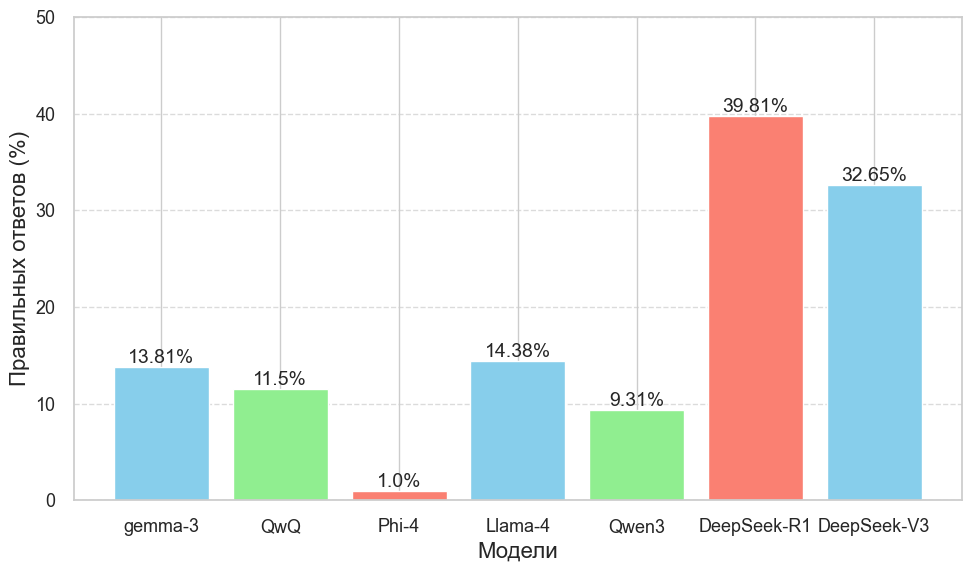

In [514]:
data = load_data('ответы моделей/combined_evaluations.json')
plot_accuracy(accuracy_results = calculate_accuracy(data))

Анализ структурных кластеров:


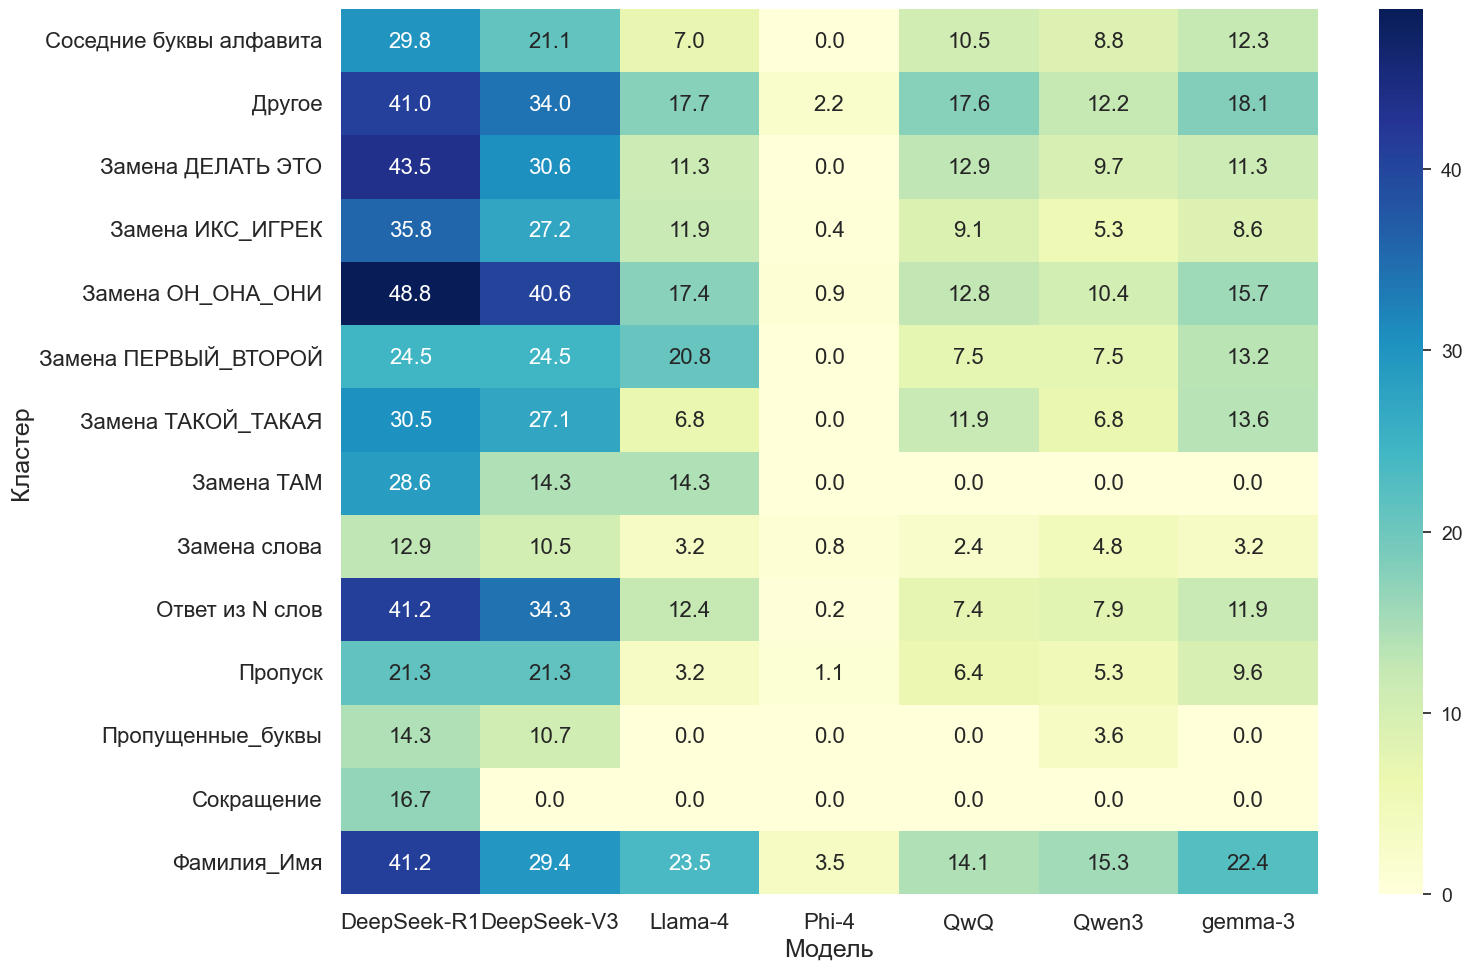

Статистика по structure_cluster:
Chi2 = 254.207, p-value = 0.0000
Результат теста Крускала-Уоллиса: p-value = 0.0000
Влияние кластера статистически значимо (p < 0.05)

Анализ тематических кластеров:


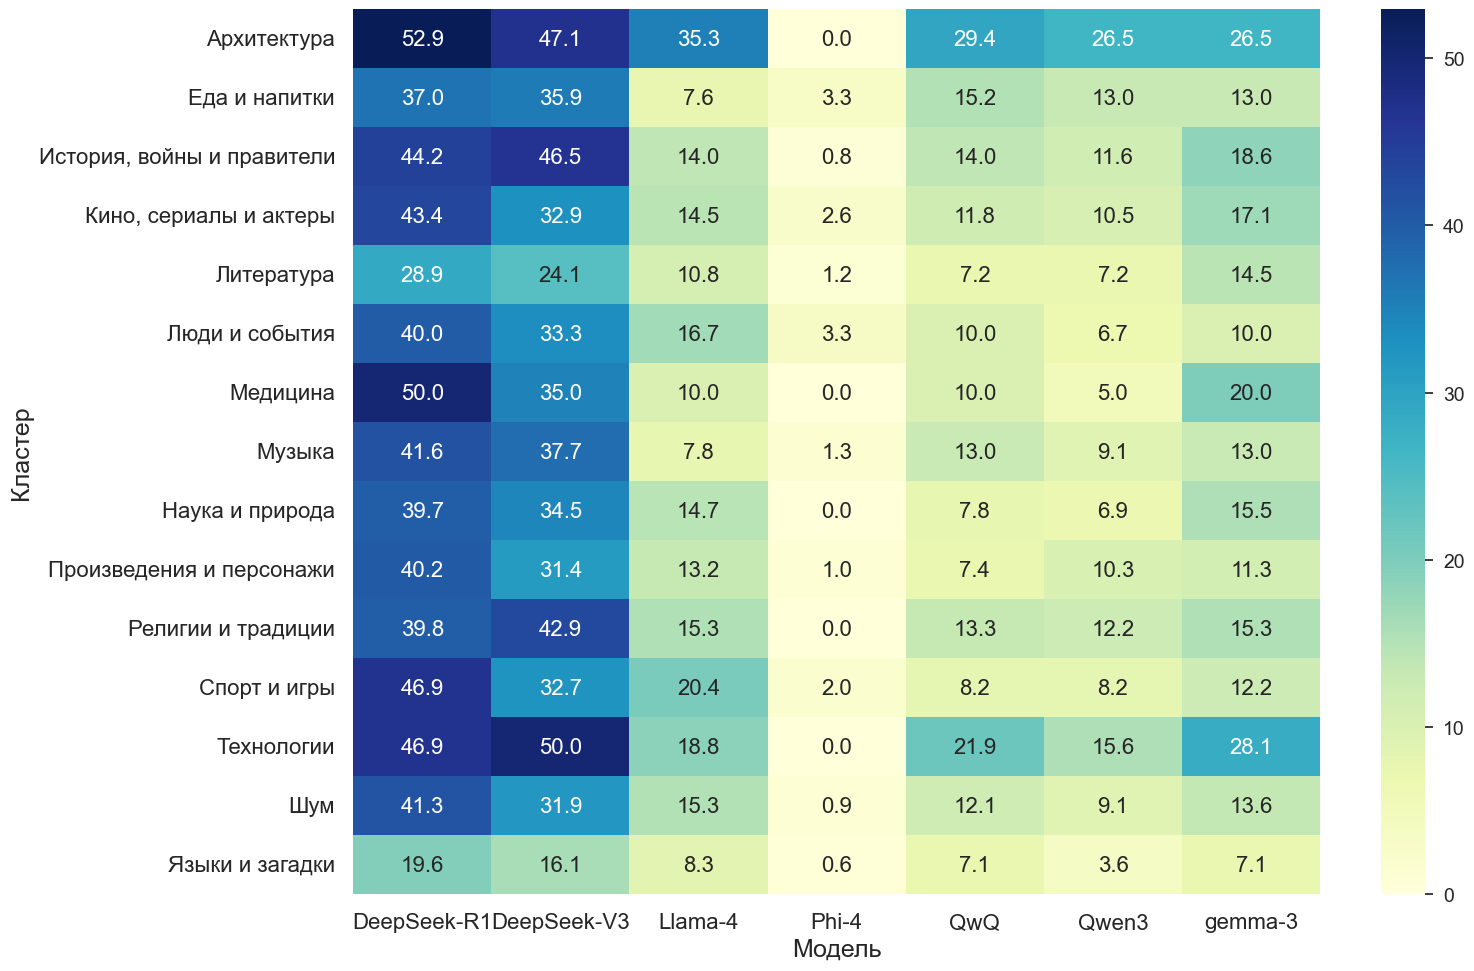

Статистика по topic_name:
Chi2 = 123.257, p-value = 0.0000
Результат теста Крускала-Уоллиса: p-value = 0.0000
Влияние кластера статистически значимо (p < 0.05)


In [ ]:
plt.rcParams.update({
    'font.size': 16,           
    'axes.titlesize': 16,      
    'axes.labelsize': 16,     
    'xtick.labelsize': 16,    
    'ytick.labelsize': 16,    
    'legend.fontsize': 12      
})

with open('ответы моделей/combined_evaluations.json', 'r', encoding='utf-8') as f:
    model_answers = json.load(f)
    
with open('merged_clusters.json', 'r', encoding='utf-8') as f:
    clusters = json.load(f)

cluster_dict = {item['id']: item for item in clusters}

data = []
for q in model_answers:
    question_id = q['question_id']
    cluster_info = cluster_dict.get(question_id, {})
    
    # Собираем результаты всех моделей
    for key in q:
        if key.startswith('evaluation_'):
            model = key.replace('evaluation_', '')
            is_correct = q[key]['is_correct']
            
            data.append({
                'question_id': question_id,
                'structure_cluster': cluster_info.get('structure_cluster', 'unknown'),
                'topic_name': cluster_info.get('topic_name', 'unknown'),
                'model': model,
                'is_correct': is_correct
            })

df = pd.DataFrame(data)

#Анализ успешности по кластерам
def analyze_and_visualize(df, cluster_type):
    success_rate = df.groupby([cluster_type, 'model'])['is_correct'].mean().unstack()
    
    plt.figure(figsize=(16, 10))
    ax = sns.heatmap(
        success_rate * 100, 
        annot=True, 
        fmt=".1f", 
        cmap="YlGnBu",
        annot_kws={"size": 16} 
    )
    
    ax.set_ylabel('Кластер', fontsize=18)
    ax.set_xlabel('Модель', fontsize=18)
    
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
    
    plt.tight_layout()
    plt.show()
    
    
    # Статистический тест
    contingency = pd.crosstab(df[cluster_type], df['is_correct'])
    chi2, p, _, _ = chi2_contingency(contingency)
    print(f"Статистика по {cluster_type}:")
    print(f"Chi2 = {chi2:.3f}, p-value = {p:.4f}")
    print(f"Результат теста Крускала-Уоллиса: p-value = {p:.4f}")
    if p < 0.05:
        print("Влияние кластера статистически значимо (p < 0.05)")
    else:
        print("Влияние кластера не статистически значимо")


print("Анализ структурных кластеров:")
analyze_and_visualize(df, 'structure_cluster')

print("\nАнализ тематических кластеров:")
analyze_and_visualize(df, 'topic_name')

df.to_csv('merged_cluster_analysis.csv', index=False, encoding='utf-8')

In [516]:
import json
import pandas as pd
from scipy.stats import kruskal



# Создание словаря кластеров
cluster_dict = {item['id']: item for item in clusters}

# Объединение данных
data = []
for q in model_answers:
    question_id = q['question_id']
    cluster_info = cluster_dict.get(question_id, {})
    for key in q:
        if key.startswith('evaluation_'):
            model = key.replace('evaluation_', '')
            is_correct = q[key]['is_correct']
            data.append({
                'question_id': question_id,
                'topic_name': cluster_info.get('topic_name', 'unknown'),
                'model': model,
                'is_correct': is_correct
            })

df = pd.DataFrame(data)

# Проведение теста Крускала-Уоллиса по структурным кластерам
grouped = df.groupby('topic_name')['is_correct'].apply(list)
stat, p_value = kruskal(*grouped)

In [517]:
stat, p_value

(123.25034320737258, 1.4501780810314233e-19)

In [518]:
import json
import pandas as pd

# 1. Загрузка всех данных
with open('ответы моделей/combined_evaluations.json', 'r', encoding='utf-8') as f:
    model_answers = json.load(f)
    
with open('merged_clusters.json', 'r', encoding='utf-8') as f:
    clusters = json.load(f)
    
with open('questions_without_material.json', 'r', encoding='utf-8') as f:
    questions = json.load(f)

# 2. Создаем словари для быстрого доступа
cluster_dict = {item['id']: item for item in clusters}
question_dict = {q['id']: q for q in questions}

# 3. Создание DataFrame с объединением всех данных
data = []
for q in model_answers:
    question_id = q['question_id']
    
    # Получаем данные из всех источников
    cluster_info = cluster_dict.get(question_id, {})
    question_info = question_dict.get(question_id, {})
    
    # Извлекаем human_success (процент взятия)
    human_success = question_info.get('Процент взятия')  # Уже число 83.0
    
    # Собираем результаты всех моделей
    for key in q:
        if key.startswith('evaluation_'):
            model = key.replace('evaluation_', '')
            is_correct = q[key]['is_correct']
            
            data.append({
                'question_id': question_id,
                'question_text': question_info.get('Вопрос'),
                'structure_cluster': cluster_info.get('structure_cluster', 'unknown'),
                'topic_name': cluster_info.get('topic_name', 'unknown'),
                'human_success': human_success,  # Процент взятия людей
                'model': model,
                'is_correct': is_correct,
                'correct_answer': question_info.get('Ответ'),
                'acceptable_answers': question_info.get('Зачет', '')
            })

df = pd.DataFrame(data)

# 4. Проверка и очистка данных
print(f"Всего записей: {len(df)}")
print(f"Пропущенные human_success: {df['human_success'].isna().sum()}")

# Удаляем вопросы без данных о human_success (если нужно)
df = df.dropna(subset=['human_success'])

# 5. Сохранение для проверки
df.to_csv('full_analysis_data.csv', index=False, encoding='utf-8')
print("Данные сохранены в full_analysis_data.csv")

# 6. Пример просмотра данных
print("\nПример данных:")
print(df[['question_id', 'structure_cluster', 'human_success', 'model', 'is_correct']].head())

Всего записей: 18200
Пропущенные human_success: 0
Данные сохранены в full_analysis_data.csv

Пример данных:
   question_id structure_cluster  human_success    model  is_correct
0            1      Замена слова           91.0  gemma-3       False
1            1      Замена слова           91.0      QwQ       False
2            1      Замена слова           91.0    Phi-4       False
3            1      Замена слова           91.0  Llama-4       False
4            1      Замена слова           91.0    Qwen3       False


In [519]:
from scipy.stats import mannwhitneyu

for cluster in df['structure_cluster'].unique():
    human = df[df['structure_cluster']==cluster]['human_success']
    model = df[df['structure_cluster']==cluster]['is_correct']*100
    stat, p = mannwhitneyu(human, model)
    print(f"{cluster}: U={stat:.1f}, p={p:.4f}")

Замена слова: U=712628.0, p=0.0000
Замена ДЕЛАТЬ ЭТО: U=156240.0, p=0.0000
Пропуск: U=390852.0, p=0.0000
Другое: U=11652189.5, p=0.0000
Ответ из N слов: U=7220640.0, p=0.0000
Замена ТАКОЙ_ТАКАЯ: U=147028.0, p=0.0000
Замена ОН_ОНА_ОНИ: U=25713765.0, p=0.0000
Фамилия_Имя: U=278460.0, p=0.0000
Замена ИКС_ИГРЕК: U=2486862.0, p=0.0000
Замена ПЕРВЫЙ_ВТОРОЙ: U=118349.0, p=0.0000
Замена ТАМ: U=2205.0, p=0.0000
Cоседние буквы алфавита: U=138852.0, p=0.0000
Пропущенные_буквы: U=36190.0, p=0.0000
Сокращение: U=1722.0, p=0.0000


In [521]:
from scipy.stats import mannwhitneyu

for cluster in df['structure_cluster'].unique():
    cluster_data = df[df['structure_cluster']==cluster]
    human = cluster_data['human_success']
    model = cluster_data['is_correct'] * 100
    
    print(cluster_data)
    if len(human) < 3 or len(model) < 3:
        print(f"{cluster}: Недостаточно данных для анализа (n < 3)")
        continue
        
    # Проверка на идентичность всех значений
    if human.nunique() == 1 and model.nunique() == 1:
        print(f"{cluster}: Все значения идентичны (human={human.iloc[0]:.1f}%, model={model.iloc[0]:.1f}%)")
        continue
    
    try:
        stat, p = mannwhitneyu(human, model)
        print(f"{cluster}: U={stat:.1f}, p={p:.4f}", end=" ")
        
        # Интерпретация
        if p < 0.05:
            mean_human = human.mean()
            mean_model = model.mean()
            if mean_human > mean_model:
                print(f"(Люди лучше на {mean_human-mean_model:.1f}%)")
            else:
                print(f"(Модели лучше на {mean_model-mean_human:.1f}%)")
        else:
            print("(Нет значимых различий)")
            
    except ValueError as e:
        print(f"{cluster}: Ошибка расчета - {str(e)}")

       question_id                                      question_text  \
0                1  В передаче Андрея Понкратова рассказывается, ч...   
1                1  В передаче Андрея Понкратова рассказывается, ч...   
2                1  В передаче Андрея Понкратова рассказывается, ч...   
3                1  В передаче Андрея Понкратова рассказывается, ч...   
4                1  В передаче Андрея Понкратова рассказывается, ч...   
...            ...                                                ...   
18111         3505  Некоторые птицы для защиты от паразитов натира...   
18112         3505  Некоторые птицы для защиты от паразитов натира...   
18113         3505  Некоторые птицы для защиты от паразитов натира...   
18114         3505  Некоторые птицы для защиты от паразитов натира...   
18115         3505  Некоторые птицы для защиты от паразитов натира...   

      structure_cluster       topic_name  human_success        model  \
0          Замена слова              Шум           

In [522]:
for cluster in df['structure_cluster'].unique():
    human = df[df['structure_cluster']==cluster]['human_success']
    model = df[df['structure_cluster']==cluster]['is_correct']*100
    stat, p = mannwhitneyu(human, model)
    print(f"{cluster}: U={stat:.1f}, p={p:.4f}, human_median={human.mean():.1f}, model_median={model.mean():.1f}")

Замена слова: U=712628.0, p=0.0000, human_median=42.8, model_median=5.4
Замена ДЕЛАТЬ ЭТО: U=156240.0, p=0.0000, human_median=48.7, model_median=17.1
Пропуск: U=390852.0, p=0.0000, human_median=47.5, model_median=9.7
Другое: U=11652189.5, p=0.0000, human_median=47.4, model_median=20.4
Ответ из N слов: U=7220640.0, p=0.0000, human_median=46.3, model_median=16.5
Замена ТАКОЙ_ТАКАЯ: U=147028.0, p=0.0000, human_median=40.9, model_median=13.8
Замена ОН_ОНА_ОНИ: U=25713765.0, p=0.0000, human_median=46.4, model_median=20.9
Фамилия_Имя: U=278460.0, p=0.0000, human_median=37.6, model_median=21.3
Замена ИКС_ИГРЕК: U=2486862.0, p=0.0000, human_median=45.2, model_median=14.1
Замена ПЕРВЫЙ_ВТОРОЙ: U=118349.0, p=0.0000, human_median=46.2, model_median=14.0
Замена ТАМ: U=2205.0, p=0.0000, human_median=54.6, model_median=8.2
Cоседние буквы алфавита: U=138852.0, p=0.0000, human_median=39.2, model_median=12.8
Пропущенные_буквы: U=36190.0, p=0.0000, human_median=45.0, model_median=4.1
Сокращение: U=1722.

In [ ]:
correct_counts = df.groupby('question_id')['is_correct'].sum().reset_index()
all_correct = correct_counts[correct_counts['is_correct'] == 4]

In [524]:
all_correct

,question_id,is_correct
22,36,4
25,39,4
40,271,4
92,325,4
94,327,4
...,...,...
2517,3426,4
2539,3448,4
2571,3488,4
2588,3506,4


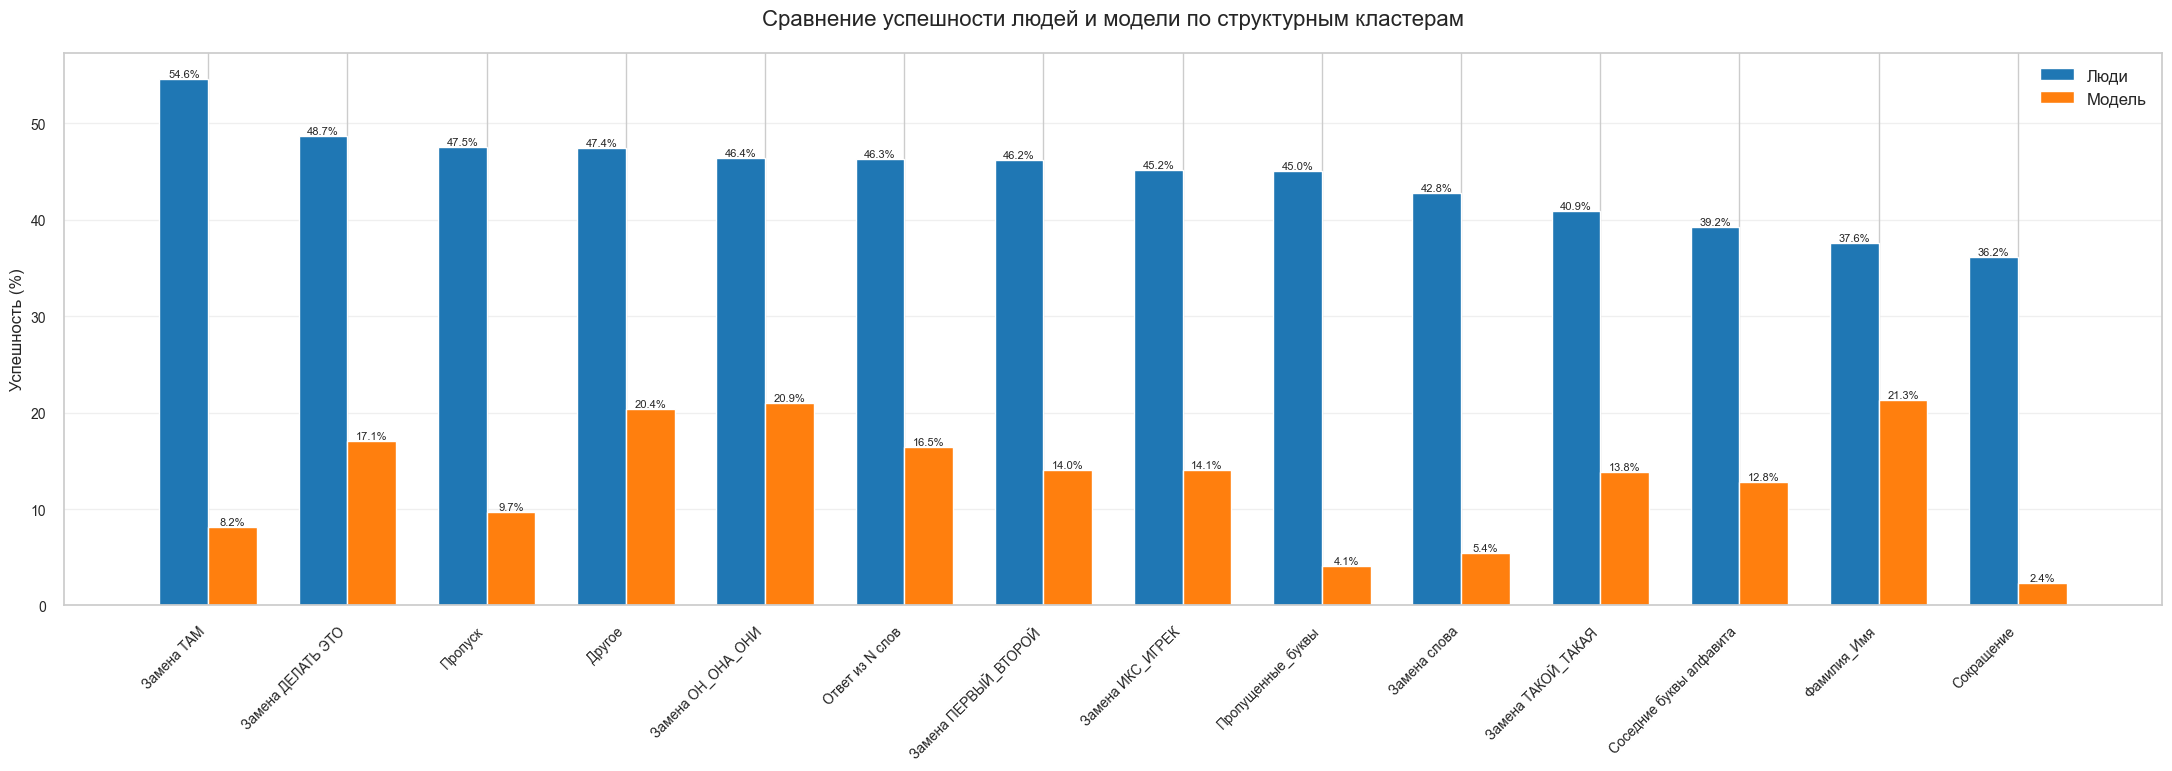

In [525]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Группируем и переводим is_correct в проценты (если исходно 0/1)
success_stats = df.groupby('structure_cluster').agg({
    'human_success': 'mean',  # Уже в %
    'is_correct': lambda x: x.mean() * 100  # Конвертируем в %
}).sort_values('human_success', ascending=False)

success_stats.rename(columns={'is_correct': 'model_success'}, inplace=True)

plt.figure(figsize=(22, 8))
bar_width = 0.35
x = np.arange(len(success_stats))

# Столбцы
bars_human = plt.bar(x - bar_width/2, success_stats['human_success'], 
                    width=bar_width, color='#1f77b4', label='Люди')
bars_model = plt.bar(x + bar_width/2, success_stats['model_success'], 
                    width=bar_width, color='#ff7f0e', label='Модель')

# Настройки
plt.title('Сравнение успешности людей и модели по структурным кластерам', pad=20, fontsize=16)
plt.ylabel('Успешность (%)', fontsize=12)
plt.xticks(x, success_stats.index, rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)

# Добавляем значения на столбцы (опционально)
for bar in bars_human + bars_model:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


success_stats = df.groupby('structure_cluster').agg({
    'human_success': 'mean',  # Уже в %
    'is_correct': lambda x: x.mean() * 100
}).sort_values('human_success', ascending=False)

success_stats.rename(columns={'is_correct': 'model_success'}, inplace=True)

In [ ]:
summary_table = df.pivot_table(
    index='structure_cluster',
    columns='model',
    values='is_correct',
    aggfunc=lambda x: round(x.mean() * 100, 1)  # Переводим в проценты и округляем
)

human_success = df.groupby('structure_cluster')['human_success'].mean().round(1)
summary_table['Human'] = human_success


cols = ['Human'] + [col for col in summary_table.columns if col != 'Human']
summary_table = summary_table[cols]


summary_table = summary_table.sort_values('Human', ascending=False)


from IPython.display import display

display(
    summary_table.style
    .background_gradient(cmap='Blues', subset=['Human'])
    .background_gradient(cmap='Greens', subset=summary_table.columns[1:])
    .set_caption('Средняя успешность ответов по кластерам (%)')
    .format('{:.1f}%')
)

model,Human,DeepSeek-R1,DeepSeek-V3,Llama-4,Phi-4,QwQ,Qwen3,gemma-3
structure_cluster,,,,,,,,
Замена ТАМ,54.6%,28.6%,14.3%,14.3%,0.0%,0.0%,0.0%,0.0%
Замена ДЕЛАТЬ ЭТО,48.7%,43.5%,30.6%,11.3%,0.0%,12.9%,9.7%,11.3%
Пропуск,47.5%,21.3%,21.3%,3.2%,1.1%,6.4%,5.3%,9.6%
Другое,47.4%,41.0%,34.0%,17.7%,2.2%,17.6%,12.2%,18.1%
Замена ОН_ОНА_ОНИ,46.4%,48.8%,40.6%,17.4%,0.9%,12.8%,10.4%,15.7%
Ответ из N слов,46.3%,41.2%,34.3%,12.4%,0.2%,7.4%,7.9%,11.9%
Замена ПЕРВЫЙ_ВТОРОЙ,46.2%,24.5%,24.5%,20.8%,0.0%,7.5%,7.5%,13.2%
Замена ИКС_ИГРЕК,45.2%,35.8%,27.2%,11.9%,0.4%,9.1%,5.3%,8.6%
Пропущенные_буквы,45.0%,14.3%,10.7%,0.0%,0.0%,0.0%,3.6%,0.0%


In [ ]:
summary_table = df.pivot_table(
    index='structure_cluster',
    columns='model',
    values='is_correct',
    aggfunc=lambda x: round(x.mean() * 100, 1)
)

human_success = df.groupby('structure_cluster')['human_success'].mean().round(1)
summary_table.insert(0, 'Human', human_success)

summary_table = summary_table.rename_axis('Структурный кластер').rename(columns={'Human': 'Люди'})

def compare_with_human(row):
    colors = []
    human_val = row['Люди']
    for item in row:
        if isinstance(item, (int, float)):
            diff = item - human_val
            if diff > 0:  # Модель лучше
                intensity = min(0.5 + diff/200, 1)  # Нормализуем разницу
                colors.append(f'background-color: rgba(0,200,0,{intensity})')
            elif diff < 0:  # Модель хуже
                intensity = min(0.5 + abs(diff)/200, 1)
                colors.append(f'background-color: rgba(200,0,0,{intensity})')
            else:
                colors.append('')
        else:
            colors.append('')
    return colors

styled_table = (summary_table.style
               .background_gradient(cmap='Blues', subset=['Люди'])  # Люди - синий
               .apply(compare_with_human, axis=1)  # Сравнение для моделей
               .format('{:.1f}%')
               .set_caption('Процент правильных ответов по кластерам')
               .set_properties(**{
                   'text-align': 'center',
                   'border': '1px solid #ddd'
               })
               .set_table_styles([
                   {'selector': 'th.col_heading', 'props': [('text-align', 'left')]},
                   {'selector': 'th.row_heading', 'props': [('text-align', 'left')]},
                   {'selector': 'td', 'props': [('text-align', 'left')]}
               ]))

styled_table = styled_table.set_properties(**{
    'width': '80px',
    'max-width': '80px',
    'min-width': '85px'
})

display(styled_table)


model,Люди,DeepSeek-R1,DeepSeek-V3,Llama-4,Phi-4,QwQ,Qwen3,gemma-3
Структурный кластер,,,,,,,,
Cоседние буквы алфавита,39.2%,29.8%,21.1%,7.0%,0.0%,10.5%,8.8%,12.3%
Другое,47.4%,41.0%,34.0%,17.7%,2.2%,17.6%,12.2%,18.1%
Замена ДЕЛАТЬ ЭТО,48.7%,43.5%,30.6%,11.3%,0.0%,12.9%,9.7%,11.3%
Замена ИКС_ИГРЕК,45.2%,35.8%,27.2%,11.9%,0.4%,9.1%,5.3%,8.6%
Замена ОН_ОНА_ОНИ,46.4%,48.8%,40.6%,17.4%,0.9%,12.8%,10.4%,15.7%
Замена ПЕРВЫЙ_ВТОРОЙ,46.2%,24.5%,24.5%,20.8%,0.0%,7.5%,7.5%,13.2%
Замена ТАКОЙ_ТАКАЯ,40.9%,30.5%,27.1%,6.8%,0.0%,11.9%,6.8%,13.6%
Замена ТАМ,54.6%,28.6%,14.3%,14.3%,0.0%,0.0%,0.0%,0.0%
Замена слова,42.8%,12.9%,10.5%,3.2%,0.8%,2.4%,4.8%,3.2%


In [ ]:
summary_table = df.pivot_table(
    index='topic_name',
    columns='model',
    values='is_correct',
    aggfunc=lambda x: round(x.mean() * 100, 1)
)


human_success = df.groupby('topic_name')['human_success'].mean().round(1)
summary_table.insert(0, 'Human', human_success)

summary_table = summary_table.rename_axis('Тематический кластер').rename(columns={'Human': 'Люди'})

def compare_with_human(row):
    colors = []
    human_val = row['Люди']
    for item in row:
        if isinstance(item, (int, float)):
            diff = item - human_val
            if diff > 0:
                intensity = min(0.5 + diff/200, 1)
                colors.append(f'background-color: rgba(0,200,0,{intensity})')
            elif diff < 0:
                intensity = min(0.5 + abs(diff)/200, 1)
                colors.append(f'background-color: rgba(200,0,0,{intensity})')
            else:
                colors.append('')
        else:
            colors.append('')
    return colors

styled_table = (summary_table.style
               .background_gradient(cmap='Blues', subset=['Люди']) 
               .apply(compare_with_human, axis=1) 
               .format('{:.1f}%')
               .set_caption('Процент правильных ответов по кластерам')
               .set_properties(**{
                   'text-align': 'center',
                   'border': '1px solid #ddd'
               })
               .set_table_styles([
                   {'selector': 'th.col_heading', 'props': [('text-align', 'left')]},  
                   {'selector': 'th.row_heading', 'props': [('text-align', 'left')]},  
                   {'selector': 'td', 'props': [('text-align', 'left')]}  
               ]))


styled_table = styled_table.set_properties(**{
    'width': '80px',
    'max-width': '80px',
    'min-width': '85px'
})

display(styled_table)

model,Люди,DeepSeek-R1,DeepSeek-V3,Llama-4,Phi-4,QwQ,Qwen3,gemma-3
Тематический кластер,,,,,,,,
Архитектура,52.7%,52.9%,47.1%,35.3%,0.0%,29.4%,26.5%,26.5%
Еда и напитки,48.1%,37.0%,35.9%,7.6%,3.3%,15.2%,13.0%,13.0%
"История, войны и правители",48.0%,44.2%,46.5%,14.0%,0.8%,14.0%,11.6%,18.6%
"Кино, сериалы и актеры",51.7%,43.4%,32.9%,14.5%,2.6%,11.8%,10.5%,17.1%
Литература,45.9%,28.9%,24.1%,10.8%,1.2%,7.2%,7.2%,14.5%
Люди и события,40.2%,40.0%,33.3%,16.7%,3.3%,10.0%,6.7%,10.0%
Медицина,45.3%,50.0%,35.0%,10.0%,0.0%,10.0%,5.0%,20.0%
Музыка,43.8%,41.6%,37.7%,7.8%,1.3%,13.0%,9.1%,13.0%
Наука и природа,41.7%,39.7%,34.5%,14.7%,0.0%,7.8%,6.9%,15.5%
